In [1]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr
from bids import BIDSLayout
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import re
import os

import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import ptitprince as pt
import dabest

from util.tasks import process_SoAS, process_libet, process_dot_motion

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

In [2]:
# some info that might be useful for reproducing results
print('Package versions:\n')
print('PyMC v%s'%pm.__version__ )
print('ArviZ v%s'%az.__version__)
print('Pandas v%s'%pd.__version__ )
print('DABEST v%s'%dabest.__version__)

Package versions:

PyMC v5.9.0
ArviZ v0.16.1
Pandas v1.5.3
DABEST v2023.02.14


In [3]:
# parse dataset
layout = BIDSLayout('data_bids_anon', validate = False)

# get subjects who completed everything through the SoA scale
sub_ids = layout.get_subjects(task = 'SoAScale')
sub_ids.sort(key = int)

In [4]:
SoAS = process_SoAS(sub_ids, layout)
libet_conds, libet_subs = process_libet(sub_ids, layout)
dot_motion = process_dot_motion(sub_ids, layout)

/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/metadpy/mle.py:529: UserWarning: Your inputs contain zeros and is not corrected.This may interfere with proper estimation of meta-d.See docstrings for more information.
  warnings.warn(


Subject 326 removed from dot motion data for NaNs.


In [5]:
print('Number of subjects with data from all tasks: %d'%len(sub_ids))
print('Excluded from libet: %d'%libet_subs.exclude.sum())
print('Excluded from dot motion: %d'%dot_motion.exclude.sum())
print('Excluded from SoAS: %d'%SoAS.exclude.sum())

Number of subjects with data from all tasks: 195
Excluded from libet: 5
Excluded from dot motion: 12
Excluded from SoAS: 21


In [6]:
# remove outliers
libet_subs = libet_subs[~libet_subs.exclude]
dot_motion = dot_motion[~dot_motion.exclude]
SoAS = SoAS[~SoAS.exclude]

dot_motion['percent control threshold'] = 100*dot_motion['control threshold']

In [7]:
data = dabest.load(
    data = libet_conds, 
    x = ['type', 'target'], y = 'estimation error (ms)', 
    id_col = 'subject',
    paired = 'baseline',
    experiment = 'target',
    delta2 = True
)

ct = pd.DataFrame()
ct['control threshold'] = 100 * dot_motion['control threshold']
ct['type'] = 'percent'
lct = pd.DataFrame()
lct['control threshold'] = dot_motion['log control threshold']
lct['type'] = 'log'
ct_df = pd.concat([ct, lct])

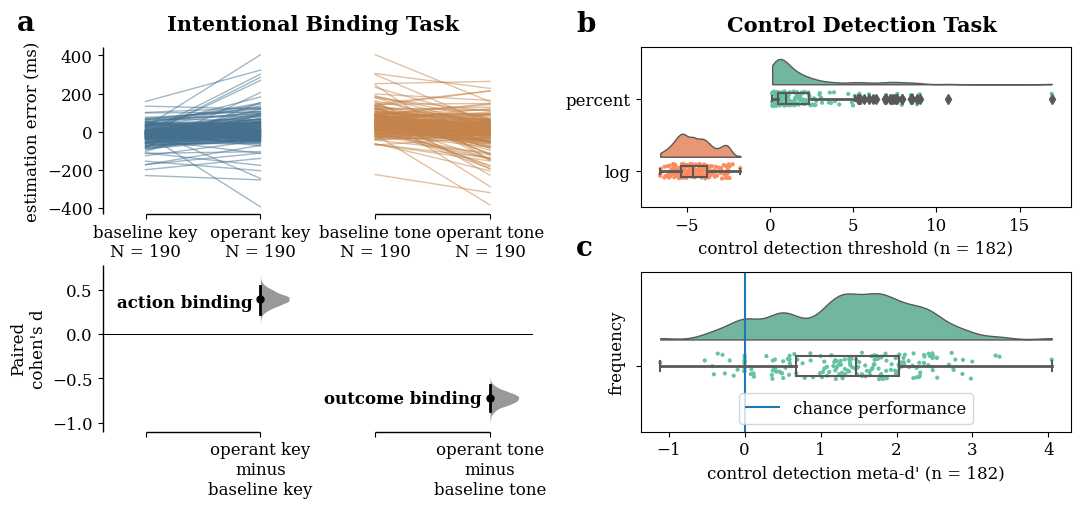

In [8]:
def add_label(ax, label, x_offset = -.2, y_offset = .1):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin + x_offset*xscale, ymax + yscale*y_offset, 
        label, size = 20, weight = 'bold'
    )

def add_title(ax, label, x_offset = .5):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin + x_offset*xscale, ymax + yscale*.1, 
        label, size = 15, weight = 'bold'
    )

fig = plt.figure(figsize = (12.5, 5))
gs = gridspec.GridSpec(2, 2, wspace = .25, hspace = .4)

# visualize intentional binding effect
left_ax = fig.add_subplot(gs[:, 0])
data.cohens_d.plot(es_marker_size = 5, ax = left_ax, show_delta2 = False)
left_ax.get_legend().remove()
add_label(left_ax, 'a')
add_title(left_ax, 'Intentional Binding Task', .15)

left_ax.text(-.25, -925, 'action binding', weight = 'bold',  size = 12)
left_ax.text(1.55, -1430, 'outcome binding', weight = 'bold',  size = 12)

# visualize distribution of dot motion measurements
ax = fig.add_subplot(gs[0, 1])
pt.RainCloud(x = 'type', y = 'control threshold', data = ct_df, orient = 'h', ax = ax)
ax.set_ylabel(None)
ax.set_xlabel('control detection threshold (n = %d)'%dot_motion.shape[0])
add_label(ax, 'b', x_offset = -.15)
add_title(ax, 'Control Detection Task', .2)

ax = fig.add_subplot(gs[1, 1])
pt.RainCloud(y = 'metad', data = dot_motion, orient = 'h', ax = ax)
ax.set_xlabel("control detection meta-d' (n = %d)"%dot_motion.shape[0])
ax.set_ylabel('frequency')
ax.axvline(0., label = 'chance performance')
ax.legend(loc = 'lower center')
add_label(ax, 'c', x_offset = -.15)

plt.savefig('Figure1.jpeg', dpi = 500, bbox_inches = 'tight')
plt.show()

In [9]:
# non-standard effect size estimates for intentional binding
data.mean_diff.results[['difference', 'ci', 'bca_low', 'bca_high']]

,difference,ci,bca_low,bca_high
0,27.850947,95,17.682661,39.249222
1,-57.888663,95,-71.267070,-46.574351


In [10]:
# standardized effect size estimates
data.cohens_d.results[['difference', 'ci', 'bca_low', 'bca_high']]

,difference,ci,bca_low,bca_high
0,0.393390,95,0.226628,0.535998
1,-0.721458,95,-0.869843,-0.575897


In [11]:
# merge sensorimotor measures
merged_sm = libet_subs.merge(dot_motion, how = 'outer', on = 'subject')
# now join agency scores
df = merged_sm.merge(SoAS, on = 'subject')

In [12]:
def sample_correlation_posterior(df, predictor, target):
    
    # drop NaNs and standardize 
    xy = df[[predictor, target]].dropna(inplace = False).to_numpy()
    xy = (xy - xy.mean(0))/xy.std(0) # standardize 

    with pm.Model() as model:
        mu = pm.Normal("mu", 0., 1., shape = 2)
        chol, corr, stds = pm.LKJCholeskyCov( # correlation matrix
            "chol", 
            n = 2, 
            eta = 2.0, 
            sd_dist = pm.Exponential.dist(1), 
            compute_corr = True
        )
        yd = pm.MvNormal("yd", mu = mu, chol = chol, observed = xy)
        trace = pm.sample(
            5000,
            tune = 2000,
            chains = 2,
            return_inferencedata = True, 
            random_seed = 0
        )
    
    # compile samples from across chains
    trc = trace.posterior.stack(draws = ("chain", "draw"))
    dist = trc['chol_corr'][0, 1].values

    # compute p-value for frequentist correlation as well
    p = pearsonr(xy[:,0], xy[:,1]).pvalue
    
    # compile summary and diagnostic stats
    stats = pd.Series({
        'predictor': predictor,
        'target': target,
        'posterior mean': dist.mean(),
        'HDI lower': az.hdi(dist, .95)[0],
        'HDI upper': az.hdi(dist, .95)[1],
        'prob. negative': (dist < 0).mean(),
        'prob. positive': (dist > 0).mean(),
        'rhat': az.rhat(trace)['chol_corr'].values[0, 1],
        'n_subjects': xy.shape[0],
        'p-value': p
    })
    
    return dist, stats # return samples from correlation posterior

def df_from_res(res, predictor, target):
    df = pd.DataFrame({'correlation': res})
    df['predictor'] = predictor
    df['target'] = target
    return df

In [13]:
post_dists = []
post_stats = []
df['type II AUROC'] = df['AUROC'] # rename variables for later plotting 
df["meta-d'"] = df['metad']
df['action binding'] = df['binding: key']
df['outcome binding'] = df['binding: tone']
for predictor in ('action binding', 'outcome binding', 'log control threshold', "meta-d'"):
    for target in ('SoPA', 'SoNA'):
        post, stats = sample_correlation_posterior(df, predictor, target)
        post_df = df_from_res(post, predictor, target)
        post_dists.append(post_df)
        post_stats.append(stats)
post_df = pd.concat(post_dists)
post_stats = pd.DataFrame(post_stats)

/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


**Note:** The `RuntimeWarning: invalid value encountered in double_scalars` message is happening because the code that computes $\hat{R}$ is computing it for each value in the $2 \times 2$ correlation matrix (`'chol_corr'`), not just the off-diagonal value we care about. Since the on-diagonal values are always $r = 1$ by definition, then `between_chain_variance` and `within_chain_variance` will always be 0, resulting in division by zero -- hence a numerical warning. In other words, the warning isn't a problem; this is expected behavior. 

In [14]:
post_stats

,predictor,target,posterior mean,HDI lower,HDI upper,prob. negative,prob. positive,rhat,n_subjects,p-value
0,action binding,SoPA,0.062531,-0.085696,0.210845,0.2069,0.7931,1.000105,169,0.406892
1,action binding,SoNA,-0.063345,-0.206500,0.090084,0.7983,0.2017,0.999902,169,0.400311
2,outcome binding,SoPA,0.075403,-0.070359,0.225004,0.1569,0.8431,1.000360,169,0.314873
3,outcome binding,SoNA,0.080898,-0.068924,0.225423,0.1456,0.8544,1.000133,169,0.279701
4,log control threshold,SoPA,0.000742,-0.153639,0.150393,0.4978,0.5022,0.999899,163,0.997140
5,log control threshold,SoNA,0.186197,0.043022,0.331698,0.0076,0.9924,1.001264,163,0.013544
6,meta-d',SoPA,0.105511,-0.045063,0.248602,0.0808,0.9192,0.999980,163,0.164175
7,meta-d',SoNA,-0.235276,-0.378430,-0.086860,0.9987,0.0013,1.000396,163,0.001751


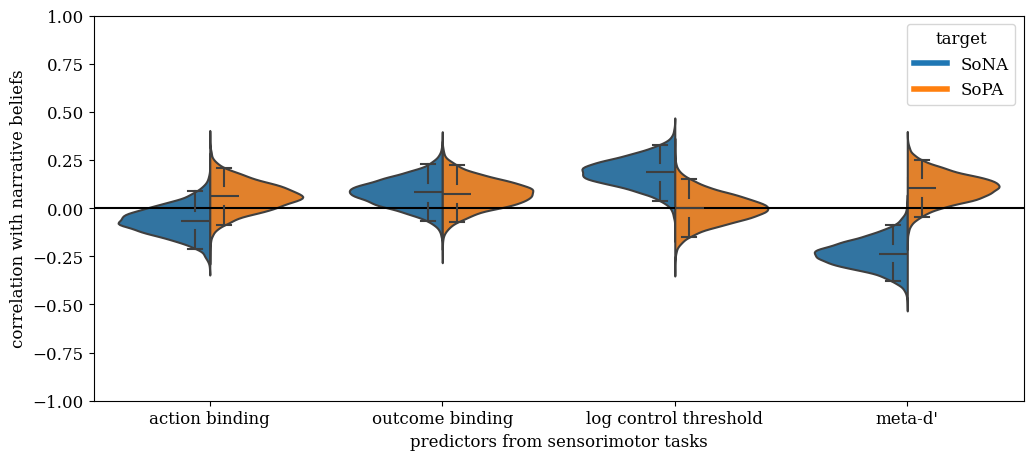

In [15]:
fig, ax = plt.subplots(figsize = (12, 5))

n_pred = post_df.predictor.unique().size
sns.violinplot(
    data = post_df,
    x = 'predictor', y = 'correlation', 
    hue = 'target', hue_order = ['SoNA', 'SoPA'],
    split = True, inner = None,
    ax = ax
)
ax.axhline(0., color = 'black', label = 'chance')
ax.set_ylim(-1, 1)

sns.boxplot(
    data = post_df,
    x = 'predictor', y = 'correlation', 
    hue = 'target', hue_order = ['SoNA', 'SoPA'],
    width = 1./n_pred, fliersize = 0., 
    whis = [2.5, 97.5], # make whiskers 95% credible interval 
    ax = ax
)
ax.legend_ = None

from matplotlib.lines import Line2D
colors = sns.color_palette()
legend_elements = [
    Line2D([0], [0], color = colors[0], lw = 4, label = 'SoNA'),
    Line2D([0], [0], color = colors[1], lw = 4, label = 'SoPA'),
]
ax.legend(handles = legend_elements, title = 'target')
ax.set_ylabel('correlation with narrative beliefs')
ax.set_xlabel('predictors from sensorimotor tasks')

plt.savefig('Figure2.jpeg', dpi = 500, bbox_inches = 'tight')
plt.show()

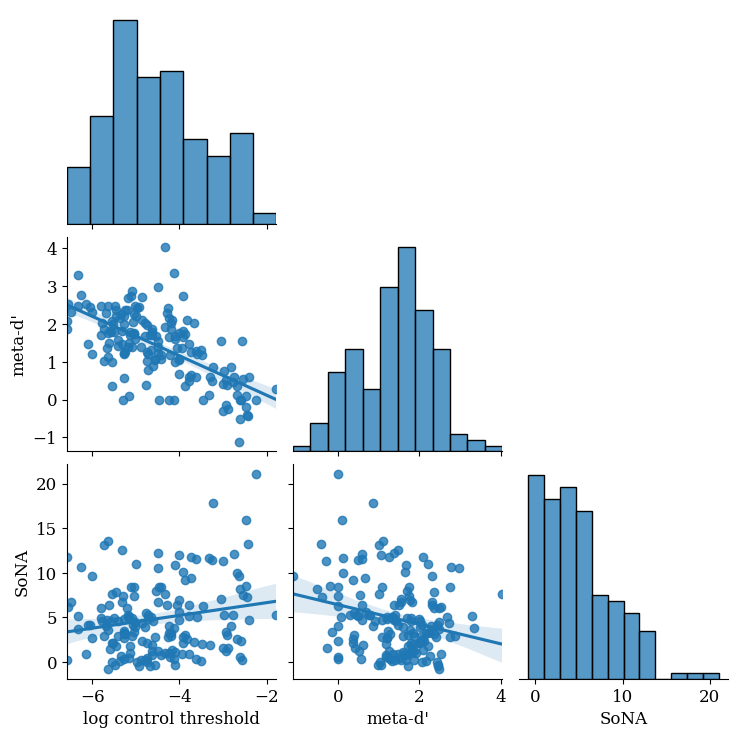

In [16]:
sns.pairplot(
    df, 
    vars = ['log control threshold', "meta-d'", 'SoNA'], 
    kind = 'reg',
    corner = True
)
plt.savefig('Figure3.jpeg', dpi = 500, bbox_inches = 'tight')

In [17]:
post, stats = sample_correlation_posterior(
    df, 'log control threshold', 'metad'
)
stats

/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


predictor         log control threshold
target                            metad
posterior mean                -0.621579
HDI lower                     -0.707684
HDI upper                     -0.520947
prob. negative                      1.0
prob. positive                      0.0
rhat                            0.99999
n_subjects                          163
p-value                             0.0
dtype: object

In [18]:
def mediation_model(x, m, y):
    with pm.Model() as model:
        x = pm.Data("x", x)
        y = pm.Data("y", y)
        m = pm.Data("m", m)

        # intercept priors
        im = pm.Normal("im", mu = 0, sigma = 1)
        iy = pm.Normal("iy", mu = 0, sigma = 1)
        # slope priors
        a = pm.Normal("a", mu = 0, sigma = 1)
        b = pm.Normal("b", mu = 0, sigma = 1)
        cprime = pm.Normal("direct effect", mu=0, sigma=1)
        # noise priors
        σm = pm.Exponential("σm", 1)
        σy = pm.Exponential("σy", 1)

        # likelihood
        pm.Normal("m_likehood", mu = im + a * x, sigma = σm, observed = m)
        pm.Normal("y_likehood", mu = iy + b * m + cprime * x, sigma = σy, observed = y)

        # calculate quantities of interest
        indirect_effect = pm.Deterministic("indirect effect", a * b)
        total_effect = pm.Deterministic("total effect", a * b + cprime)

    return model

In [19]:
def normalize(x):
    return (x - x.mean())/x.std()

_df = df[['log control threshold', 'metad', 'SoNA']].dropna(inplace = False)
xmy_model = mediation_model(
    x = normalize(_df['log control threshold']), 
    m = normalize(_df['metad']), 
    y = normalize(_df['SoNA'])
)
mxy_model = mediation_model(
    m = normalize(_df['log control threshold']), 
    x = normalize(_df['metad']), 
    y = normalize(_df['SoNA'])
)

/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [20]:
with xmy_model:
    xmy_result = pm.sample(
        5000,
        tune = 2000,
        chains = 2,
        target_accept = 0.9,
        random_seed = 0,
        return_inferencedata = True,
        idata_kwargs = {"dims": {"x": ["obs_id"], "m": ["obs_id"], "y": ["obs_id"]}},
    )
with mxy_model:
    mxy_result = pm.sample(
        5000,
        tune = 2000,
        chains = 2,
        target_accept = 0.9,
        random_seed = 0,
        return_inferencedata = True,
        idata_kwargs = {"dims": {"x": ["obs_id"], "m": ["obs_id"], "y": ["obs_id"]}},
    )

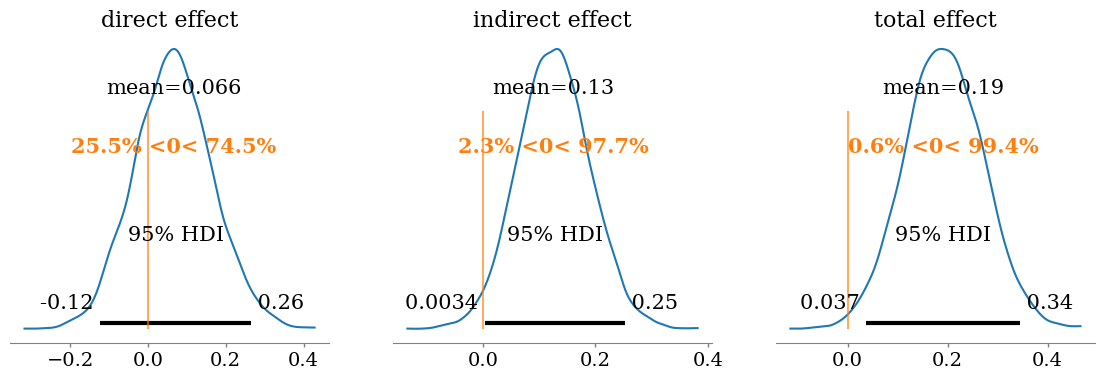

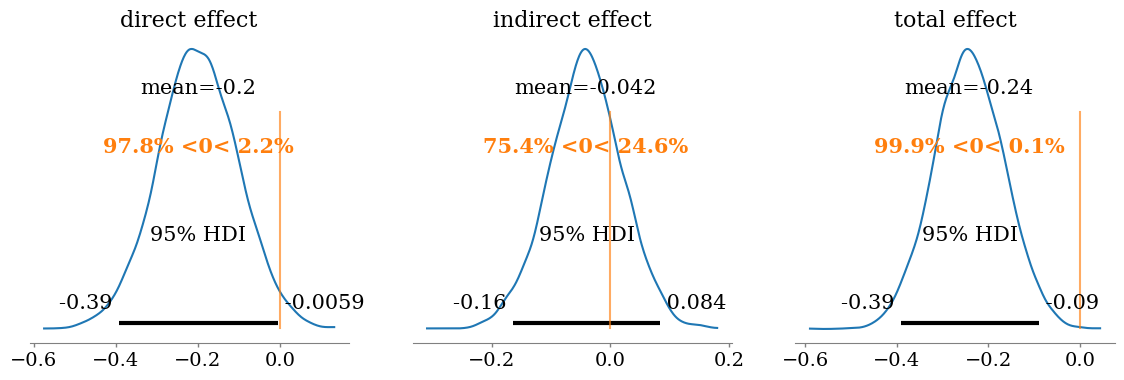

In [21]:
plot_kwargs = dict(
    var_names = ["direct effect", "indirect effect", "total effect"],
    ref_val = 0,
    hdi_prob = 0.95,
    figsize = (14, 4),
)
ax = az.plot_posterior(
    xmy_result,
    **plot_kwargs
)
ax = az.plot_posterior(
    mxy_result,
    **plot_kwargs
)

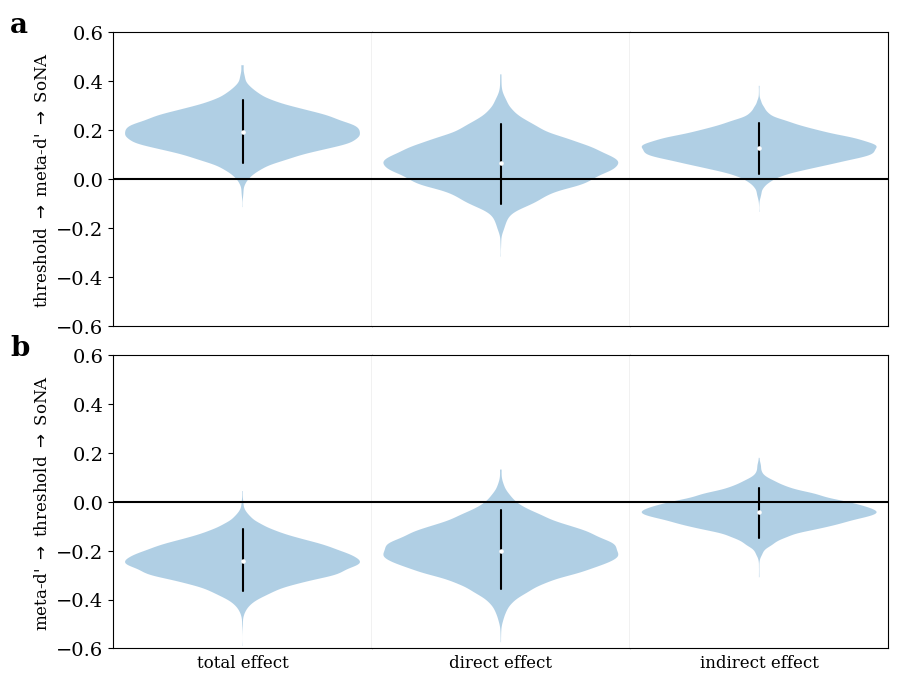

In [22]:
fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(2, 3, wspace = 0, hspace = .1)
top_axes = [
    fig.add_subplot(gs[0, 0]), 
    fig.add_subplot(gs[0, 1]), 
    fig.add_subplot(gs[0, 2])
]
bottom_axes = [
    fig.add_subplot(gs[1, 0]), 
    fig.add_subplot(gs[1, 1]), 
    fig.add_subplot(gs[1, 2])
]

plot_kwargs = dict(
    var_names = ["total effect", "direct effect", "indirect effect"],
    hdi_prob = 0.9,
    quartiles = False,
)
az.plot_violin(
    xmy_result,
    ax = top_axes,
    **plot_kwargs
)
az.plot_violin(
    mxy_result,
    ax = bottom_axes,
    **plot_kwargs
)
for ax in top_axes + bottom_axes:
    ax.set_ylim(-.6, .6)
    ax.set_title(' ')
    ax.axhline(0., color = 'black')
for i in range(1, (len(top_axes))):
    top_axes[i].get_yaxis().set_visible(False)
    bottom_axes[i].get_yaxis().set_visible(False)
bottom_axes[0].set_xlabel('total effect')
bottom_axes[1].set_xlabel('direct effect')
bottom_axes[2].set_xlabel('indirect effect')
top_axes[0].set_ylabel(r"threshold $\rightarrow$ meta-d' $\rightarrow$ SoNA")
bottom_axes[0].set_ylabel(r"meta-d' $\rightarrow$ threshold $\rightarrow$ SoNA")

add_label(top_axes[0], 'a', -.4, 0.)
add_label(bottom_axes[0], 'b', -.4, 0.)

plt.savefig('Figure4.jpeg', dpi = 500, bbox_inches = 'tight')
plt.show()

In [23]:
## compute corrs for extra predictors (either predictors used in previous
## versions that we still wanna report for transparency, or alternative 
## predictors requested by reviewers that we choose not to focus on in Fig. 2)

# recall we previously flipped the sign in tone binding in tasks.py,
# such that more positive == "more binding" for both measures 
df['intentional binding (combined)'] = df['binding: tone'] + df['binding: key']
post_stats2 = []
for predictor in ('intentional binding (combined)', 'type II AUROC'): 
    for target in ('SoPA', 'SoNA'):
        post, stats = sample_correlation_posterior(df, predictor, target)
        post_df = df_from_res(post, predictor, target)
        post_stats2.append(stats)
post_stats2 = pd.DataFrame(post_stats2)
post_stats = pd.concat([post_stats, post_stats2])

/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/agency-battery/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [24]:
post_stats2

,predictor,target,posterior mean,HDI lower,HDI upper,prob. negative,prob. positive,rhat,n_subjects,p-value
0,intentional binding (combined),SoPA,0.095033,-0.054671,0.239800,0.1040,0.8960,1.000315,169,0.202511
1,intentional binding (combined),SoNA,0.025595,-0.121132,0.171416,0.3694,0.6306,0.999962,169,0.723040
2,type II AUROC,SoPA,0.099406,-0.052988,0.242484,0.0952,0.9048,1.000243,163,0.186945
3,type II AUROC,SoNA,-0.296330,-0.437050,-0.160680,1.0000,0.0000,1.000251,163,0.000075


In [25]:
## correct frequentist p-values for multiple comparisons using
## the two stage step-up method of Benjamini and Hochberg
reject, p_corr, _, _ = multipletests(
    post_stats['p-value'], 
    method = 'fdr_tsbh', alpha = .05
)
post_stats['corrected p-value'] = p_corr
post_stats['reject'] = reject
post_stats[['predictor', 'target', 'p-value', 'corrected p-value', 'reject']]

,predictor,target,p-value,corrected p-value,reject
0,action binding,SoPA,0.406892,0.406892,False
1,action binding,SoNA,0.400311,0.406892,False
2,outcome binding,SoPA,0.314873,0.393592,False
3,outcome binding,SoNA,0.279701,0.393592,False
4,log control threshold,SoPA,0.997140,0.830950,False
5,log control threshold,SoNA,0.013544,0.045147,True
6,meta-d',SoPA,0.164175,0.337518,False
7,meta-d',SoNA,0.001751,0.008757,True
0,intentional binding (combined),SoPA,0.202511,0.337518,False
1,intentional binding (combined),SoNA,0.723040,0.657309,False
